<a href="https://colab.research.google.com/github/NaviaEddy/SIS421_LAB01/blob/main/Lab1_NaviaCondoriEddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importamos las librerias
import torch
import torchvision
import torch.onnx
!pip install onnxruntime
import onnxruntime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
device

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.1 MB/s eta 0:00:00


'cpu'

In [ ]:
#Importamos el dataset
data = pd.read_csv('/content/mnist_procesado.csv' )

y = data.iloc[:, 0].values
X = data.iloc[:, 1:].values

# Normalizar las características
X_train = X / 255.0
y_train = y.astype(int)

print(X_train.shape, y_train.shape)

(29900, 784) (29900,)


In [ ]:
# Obtener las etiquetas de clase
clases = data.iloc[:, 0]

# Determinar el número de clases únicas
num_classes = clases.nunique()

print("Número de clases:", num_classes)

Número de clases: 10


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = Dataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True)
x, y = next(iter(dataloader))

x.shape, y.shape

(torch.Size([200, 784]), torch.Size([200]))

In [ ]:
def save_checkpoint(model, optimizer, epoch, checkpoint_dir):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch}.pt"
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint guardado en '{checkpoint_path}'")

In [ ]:
#Creamos el MLP

def build_model(D_in=784, H=200, D_out=10):
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
    )
    return model

def fit(model, dataloader, epochs=1000, log_each=1, checkpoint_interval=20, checkpoint_dir='./checkpoints_lr0.01_'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    l = []
    model.train()
    for e in range(1, epochs+1):
        _l = []
        for x_b, y_b in dataloader:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        l.append(np.mean(_l))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f}")
        if e % checkpoint_interval == 0:
            save_checkpoint(model, optimizer, e, checkpoint_dir)
    return {'epoch': list(range(1, epochs+1)), 'loss': l}

In [ ]:
model = build_model()
hist = fit(model, dataloader)

Epoch 1/1000 loss 2.25656
Epoch 2/1000 loss 2.09037
Epoch 3/1000 loss 1.70480
Epoch 4/1000 loss 1.11201
Epoch 5/1000 loss 0.69125
Epoch 6/1000 loss 0.49040
Epoch 7/1000 loss 0.39169
Epoch 8/1000 loss 0.33586
Epoch 9/1000 loss 0.30057
Epoch 10/1000 loss 0.27516
Epoch 11/1000 loss 0.25635
Epoch 12/1000 loss 0.24139
Epoch 13/1000 loss 0.22994
Epoch 14/1000 loss 0.21965
Epoch 15/1000 loss 0.21111
Epoch 16/1000 loss 0.20363
Epoch 17/1000 loss 0.19742
Epoch 18/1000 loss 0.19167
Epoch 19/1000 loss 0.18694
Epoch 20/1000 loss 0.18258
Checkpoint guardado en './checkpoints_lr0.01_/checkpoint_epoch_20.pt'
Epoch 21/1000 loss 0.17836
Epoch 22/1000 loss 0.17496
Epoch 23/1000 loss 0.17144
Epoch 24/1000 loss 0.16830
Epoch 25/1000 loss 0.16556
Epoch 26/1000 loss 0.16287
Epoch 27/1000 loss 0.16050
Epoch 28/1000 loss 0.15770
Epoch 29/1000 loss 0.15570
Epoch 30/1000 loss 0.15369
Epoch 31/1000 loss 0.15160
Epoch 32/1000 loss 0.14985
Epoch 33/1000 loss 0.14850
Epoch 34/1000 loss 0.14652
Epoch 35/1000 loss 0.

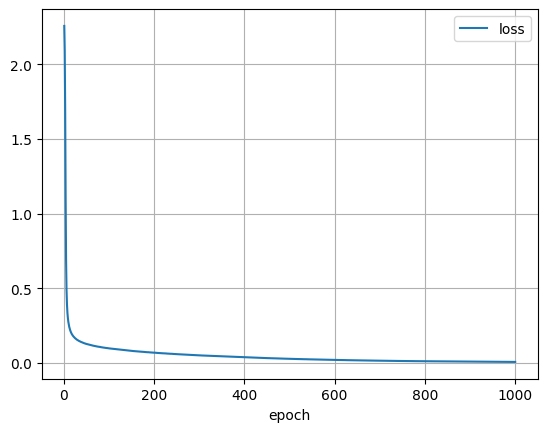

In [ ]:
fig = plt.figure(dpi=100)
ax = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', grid=True, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def evaluate(x):
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

In [ ]:
#Evaluamos las metricas
y_pred = evaluate(torch.from_numpy(X_train).float())
accuracy_score(y_train, y_pred.cpu().numpy())

0.9993311036789297

# EXPORTAMOS EL MODELO

# TORCHSCRIPT

In [ ]:
#Exportamos el modelo y lo guardamos por tracing
example_input = torch.rand(1, 784)
traced_script_module = torch.jit.trace(model, example_input)
os.makedirs('/content/export_tracing', exist_ok=True)
exported_model_path = os.path.join('/content/export_tracing', 'tracing_model.zip')
traced_script_module.save(exported_model_path)
print(f"Modelo exportado a '{exported_model_path}'")

Modelo exportado a '/content/export_tracing/tracing_model.zip'


In [ ]:
#Exportamos el modelo y lo guardamos por scripting
scripted_model = torch.jit.script(model.cpu())
os.makedirs('/content/export_scripting', exist_ok=True)
exported_model_path = os.path.join('/content/export_scripting', 'scripting_model.zip')
scripted_model.save('model.zip')

# ONNIX

In [ ]:
#Exportamos el modelo y lo guardamos por onnx

!pip install onnx

example_input = torch.rand(1, 784)
y = model.cpu()(example_input)

os.makedirs('/content/export_onnx', exist_ok=True)

# Exportar el modelo a ONNX
torch.onnx.export(model,                    # el modelo PyTorch
                  example_input,            # un ejemplo del input
                  os.path.join('/content/export_onnx', "onnx_model.onnx"),  # ruta completa del archivo para guardar el modelo
                  export_params=True,       # guardar los pesos de la red neuronal
                  opset_version=10,         # versión de ONNX
                  do_constant_folding=True, # aplicar optimizaciones
                  input_names=['input'],    # nombre de los inputs en ONNX
                  output_names=['output'],  # nombre de los outputs en ONNX
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})  # ejes dinámicos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 35.4 MB/s eta 0:00:00
